## train with finetune data
Goal here was to test whether simply increasing learning rate was enough to abolish drops in accuracy that depend on number of distractors, or whether (alternativley) abolishing the effect in part depends on increasing the training data.

In [39]:
import os
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import searchnets
from searchnets.utils.general import reorder_paths

In [2]:
results_dir = Path('../../../data/results/')
data_prep_dir = Path('../../../data/data_prepd_for_nets/')

In [3]:
stims = ('RVvGV', 'RVvRHGV', '2_v_5')

In [6]:
data_gz_finetune_paths = sorted(list(data_prep_dir.glob('alexnet*finetune*gz')))
data_gz_finetune_paths = [str(path) for path in data_gz_finetune_paths]
data_gz_finetune_paths = reorder_paths(data_gz_finetune_paths, stims)

In [7]:
train_types = ('finetune', 'train_finetune_data', 'train')

In [27]:
data_gz_paths = []
results_gz_paths = []

for train_type in train_types:
    if 'finetune' in train_type:
        data_gz_paths.extend(data_gz_finetune_paths)
    else:
        data_gz_train_paths = []
        for stim in stims:
            data_gz_train_paths.append(
                list(data_prep_dir.glob(f'alexnet*_train_{stim}_data.gz'))[0]
            )
        data_gz_train_paths = [str(path) for path in data_gz_train_paths]
        data_gz_train_paths = reorder_paths(data_gz_train_paths, stims)
        data_gz_paths.extend(data_gz_train_paths)

    results_gz_paths_this_train_type = []
    for stim in stims:
        results_gz_paths_this_train_type.append(
            list(results_dir.glob(f'alexnet_{train_type}_{stim}/*alexnet*gz'))[0]
        )
    results_gz_paths_this_train_type = [
        str(path) for path in results_gz_paths_this_train_type
    ]
    results_gz_paths_this_train_type = reorder_paths(
        results_gz_paths_this_train_type, stims)
    results_gz_paths.extend(results_gz_paths_this_train_type)

In [33]:
test_csv_path = '../../../data/csv/alexnet_finetune_train_finetune_data_train.csv'

In [34]:
searchnets.utils.general.results_csv(data_prep_dir,
                                     results_dir,
                                     test_csv_path=test_csv_path,
                                     nets=('alexnet',),
                                     train_types=train_types,
                                     stims=stims,
                                     target_condition=('present', 'absent', 'both'),
                                     data_gz_paths=data_gz_paths,
                                     results_gz_paths=results_gz_paths)

In [35]:
atft_df = pd.read_csv(test_csv_path)

In [36]:
atft_df.head()

,Unnamed: 0,net_name,train_type,net_number,stimulus,set_size,target_condition,accuracy,hit_rate,false_alarm_rate,d_prime
0,0,alexnet,finetune,0,RVvGV,1,present,1.00,NaN,NaN,NaN
1,1,alexnet,finetune,0,RVvGV,2,present,1.00,NaN,NaN,NaN
2,2,alexnet,finetune,0,RVvGV,4,present,1.00,NaN,NaN,NaN
3,3,alexnet,finetune,0,RVvGV,8,present,0.92,NaN,NaN,NaN
4,4,alexnet,finetune,0,RVvGV,1,absent,1.00,NaN,NaN,NaN


In [40]:
pal = sns.color_palette('muted')

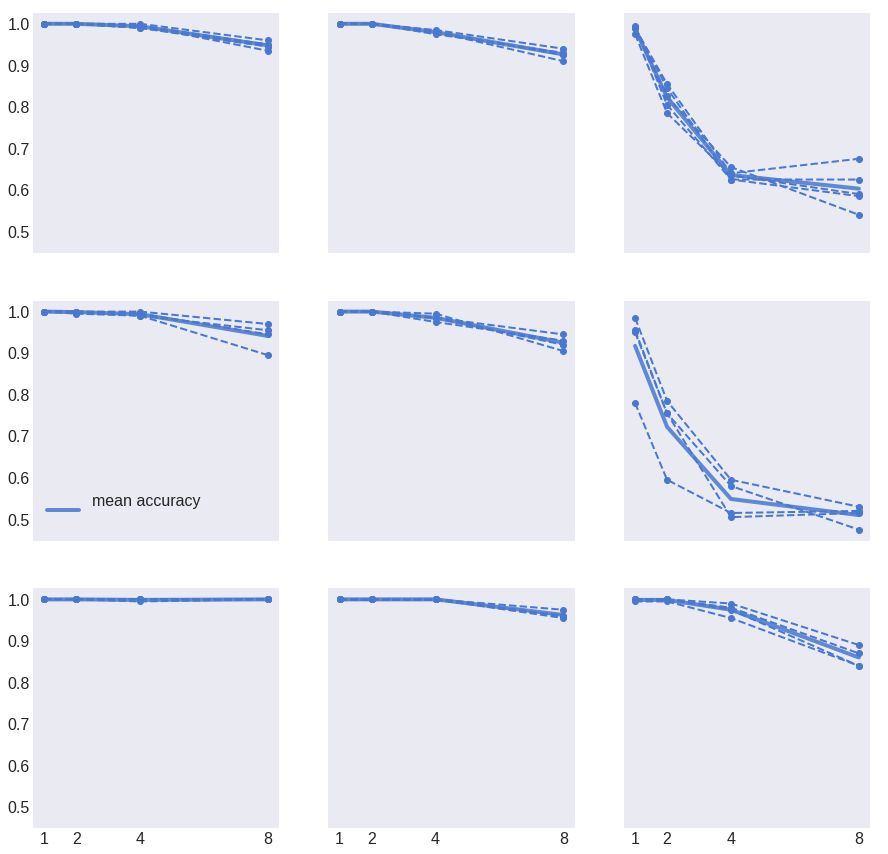

In [41]:
save_as = '../../static/fig3/alexnet-finetune-train-w-finetune-train-ipynb.png'

figsize=(15,15)
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=figsize)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

net_name = 'alexnet'
for row, train_type in enumerate(train_types):
    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['feature', 'conjunction', 'spatial configuration'],
        ['RVvGV', 'RVvRHGV', '2_v_5'])):
            if row==1 and col==0:
                add_legend=True
            else:
                add_legend=False

            both_color = pal[0]
            mn_both_color = pal[0]
                
            searchnets.plot.metric_v_set_size_df(df=atft_df, net_name=net_name,
                                                 train_type=train_type, 
                                                 stimulus=stim_abbrev,
                                                 metric='accuracy', 
                                                 conditions=['both'],
                                                 both_color=both_color,
                                                 mn_both_color=mn_both_color,
                                                 set_ylim=False,
                                                 ax=ax[row, col],
                                                 ylim=(0.5, 1.05),
                                                 add_legend=add_legend,
                                                 save_as=save_as)

Above result suggests that, no, simply increaseing the learning rate was not enough.